In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from IPython import display as ds
import matplotlib.image as mpimg
import cv2
import tensorflow as tf
import math

%matplotlib inline

/home/kvpcloud/.conda/envs/p3_gpu/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

Default GPU Device: /device:GPU:0


In [3]:
class Dataset:
    main = 'dataset/UCSD_Anomaly_Dataset.v1p2'
    train_images = np.load('{}/train.npy'.format(main))
    train_images_ = np.load('{}/train_.npy'.format(main))
    test_images = np.load('{}/test.npy'.format(main))
    test_images_ = np.load('{}/test_.npy'.format(main))

In [4]:
Dataset.train_images.shape

(200, 158, 238, 3)

In [5]:
Dataset.train_images[0]

array([[[0.36078431, 0.36078431, 0.36078431],
        [0.35686275, 0.35686275, 0.35686275],
        [0.31764706, 0.31764706, 0.31764706],
        ...,
        [0.16470588, 0.16470588, 0.16470588],
        [0.22352941, 0.22352941, 0.22352941],
        [0.29019608, 0.29019608, 0.29019608]],

       [[0.2745098 , 0.2745098 , 0.2745098 ],
        [0.2627451 , 0.2627451 , 0.2627451 ],
        [0.27843137, 0.27843137, 0.27843137],
        ...,
        [0.18823529, 0.18823529, 0.18823529],
        [0.19215686, 0.19215686, 0.19215686],
        [0.33333333, 0.33333333, 0.33333333]],

       [[0.30588235, 0.30588235, 0.30588235],
        [0.32941176, 0.32941176, 0.32941176],
        [0.3372549 , 0.3372549 , 0.3372549 ],
        ...,
        [0.24705882, 0.24705882, 0.24705882],
        [0.16862745, 0.16862745, 0.16862745],
        [0.28235294, 0.28235294, 0.28235294]],

       ...,

       [[0.41960784, 0.41960784, 0.41960784],
        [0.41960784, 0.41960784, 0.41960784],
        [0.43137255, 0

In [6]:
class Params:
    latent_feature_count = [10,10,3]
    cnn_epochs = 60
    rbf_epochs = 60
    reduced_feature_rbf_count = 300
    frames_for_anomaly = 20
    frames_per_batch = frames_for_anomaly * 6
    test_batch_size = frames_for_anomaly * 2

In [7]:
class Network:
    
    def __init__(self):
        self.graph = tf.Graph()
        with self.graph.as_default():
            with tf.name_scope('Input'):
                self.x = tf.placeholder(tf.float32, shape=(None, 158, 238, 3), name='X')
                self.x_ = tf.placeholder(tf.float32, shape=(None, 158, 238, 3), name='X_')

        self.encoder, self.decoder, self.rbf = self.build_network(self.x)

    def build_network(self, x):
        def encoder(x):
            with self.graph.as_default():
                with tf.variable_scope('CNN/Encoder', reuse=tf.AUTO_REUSE):
                    x = tf.layers.conv2d(x, filters=32, kernel_size=(5,5), strides=(1,1), activation=tf.nn.relu)
                    print('After 1st Conv', x.get_shape())
                    print(x)
                    tf.summary.image('encoder_hidden_1', x[:,:,:,0:3],max_outputs=1)
                    
                    x = tf.layers.max_pooling2d(x, pool_size=(5,5), strides=(1,1), )
                    print('After 1st Pooling', x.get_shape())

                    x = tf.layers.conv2d(x, filters=16, kernel_size=(5,5), strides=(1,1), activation=tf.nn.relu)
                    print('After 2nd Conv', x.get_shape())
                    tf.summary.image('encoder_hidden_2', x[:,:,:,0:3],max_outputs=1)
                    
                    x = tf.layers.max_pooling2d(x, pool_size=(5,5), strides=(1,1))
                    print('After 2nd Pooling', x.get_shape())

                    x = tf.layers.conv2d(x, filters=8, kernel_size=(5,5), strides=(1,1), activation=tf.nn.relu)
                    print('After 3rd Conv', x.get_shape())
                    tf.summary.image('encoder_hidden_3', x[:,:,:,0:3],max_outputs=1)
                    
                    encoded = tf.layers.max_pooling2d(x, pool_size=(5,5), strides=(1,1))
                    print('After 3rd Pooling (Final Encoded)', x.get_shape())
                    tf.summary.image('encoder_hidden_final', encoded[:,:,:,0:3], max_outputs=1)
                    
                    with tf.name_scope('Latent'):
                    
                        self.latent = tf.layers.dense(tf.contrib.layers.flatten(encoded), #depricated
                                                  units=np.prod(Params.latent_feature_count), 
                                                  activation=tf.nn.relu)

                        print('Latent', self.latent.get_shape())
                        tf.summary.histogram('Latent', self.latent)

                
            return encoded, self.latent

        def decoder(encoded):
            with self.graph.as_default():
                with tf.variable_scope('CNN/Decoder', reuse=tf.AUTO_REUSE):
                    #x = tf.reshape(encoded, [-1] + Params.latent_feature_count)
                    x = encoded
                    x = tf.layers.conv2d_transpose(x, filters=8, kernel_size=(5,5), strides=(1,1), activation=tf.nn.relu)
                    print('After 1st conv transpose', x.get_shape())
                    tf.summary.image('decoder_hidden_1', x[:,:,:,0:3],max_outputs=1)
                    
                    x = tf.layers.conv2d_transpose(x, filters=16, kernel_size=(5,5), strides=(1,1), activation=tf.nn.relu)
                    print('After 2nd conv transpose', x.get_shape())
                    tf.summary.image('decoder_hidden_2', x[:,:,:,0:3],max_outputs=1)
                    
                    x = tf.layers.conv2d_transpose(x, filters=32, kernel_size=(5,5), strides=(1,1), activation=tf.nn.relu)
                    print('After 3rd conv transpose', x.get_shape())
                    tf.summary.image('decoder_hidden_3', x[:,:,:,0:3],max_outputs=1)
                    
                    x = tf.layers.conv2d_transpose(x, filters=32, kernel_size=(5,5), strides=(1,1), activation=tf.nn.relu)
                    print('After 4th conv transpose', x.get_shape())
                    tf.summary.image('decoder_hidden_4', x[:,:,:,0:3],max_outputs=1)
                    
                    x = tf.layers.conv2d_transpose(x, filters=3, kernel_size=(5,5), strides=(1,1), activation=tf.nn.relu)
                    print('After 5th conv transpose', x.get_shape())
                    tf.summary.image('decoder_hidden_5', x[:,:,:,0:3],max_outputs=1)
                    
                    decoded = tf.layers.conv2d_transpose(x, filters=3, kernel_size=(5,5), strides=(1,1), activation=tf.nn.sigmoid)
                    print('After 6th conv transpose (final decoded)', decoded.get_shape())
                    tf.summary.image('decoder_hidden_decoded', decoded[:,:,:,0:3],max_outputs=1)

            return decoded
        
    
        def rbf(lstm_output):
            with self.graph.as_default():
                def get_cost(U, Z, Q): 

                    cost = - (-U - tf.log(Z)) 
                    return tf.reduce_mean(cost)

                f = Params.reduced_feature_rbf_count #np.prod(Params.latent_feature_count)


                with tf.variable_scope('RBF'):
                    X = lstm_output

                    mu = tf.layers.dense(X, f, activation=None, name='Mean')
                    #mu = tf.Variable(tf.random_uniform([1,f], minval=0.1, dtype=tf.float32))
                    mu = tf.print(mu, [mu], "************ Mu ")

                    #Q_ = tf.Variable(tf.truncated_normal([f], mean = 1)) 
                    global_step = tf.Variable(0, trainable=False)

                    sd = tf.Variable(tf.random_uniform([f], minval=0.1, dtype=tf.float32), name='StandardDeviation')

                    sigma = tf.square(sd)
                    sigma = tf.print(sigma, [sigma], "************ Sigma (squared) ")
                    sigma_inverse = tf.reciprocal(sigma)
                    sigma_inverse = tf.print(sigma_inverse, [sigma_inverse], '************* sigma_inverse')

                    cov_inverse = tf.diag(sigma_inverse)

                    det_sigma = tf.reduce_prod(sigma) #tf.pow(sigma, 0.5))

                    z = tf.multiply(2*math.pi, det_sigma)
                    z = tf.print(z, [z], ' ******* z')

                    with tf.variable_scope('Likelihood'):

                        M = X - mu

                        energy = tf.matmul(tf.matmul(M,cov_inverse), tf.transpose(M)) 
                        energy = tf.print(energy, [energy], '*********** energy after matmul', summarize=30)

                        energy = tf.matrix_diag_part(energy)
                        #print("Energy after matmul", energy.get_shape())


                        #energy = tf.reduce_sum(energy, axis = 1, keepdims = True)
                        energy = tf.print(energy, [energy], '*********** Energy after summation', summarize=30)
                        print('Energy after summation ', energy.get_shape())

                        print('X', X.get_shape())
                        print('Covariance', cov_inverse.get_shape())

                        expnt = tf.exp(-1 * tf.multiply(energy, 0.5))
                        print('exponent', expnt.get_shape())
                        expnt = tf.print(expnt, [expnt], "********* Exponent")

                        Y_ = expnt #tf.divide(expnt, z) #expnt #tf.nn.sigmoid(expnt) #tf.divide(expnt, z)


                        #Y_ = tf.layers.dense(Y_, 1)
                        rbf_out = Y_ #tf.reduce_mean(Y_) # tf.layers.dense(Y_, 1)
                        Y_ = tf.print(Y_, [Y_], 'XXXXXXXXXXXXXXXXXXXX Liklihood XXXXXXXXXXXXXXXXXXXXXXXXXXXX')
                        print('Y_', Y_.get_shape())

                    with tf.variable_scope('Loss'):
                        #cost = -1 * tf.log(Y_ + 0.0001) # Adding a small delta because log is not a continuous function. 
                        cost = energy #+ tf.log(z)
                        cost = tf.print(cost,[cost], "******** Cost(always postive)")
                        loss = tf.reduce_mean(cost) #get_cost(U, Z, Q) # 1- Y_[0]
                        loss = tf.print(loss, [loss], "**************** Loss")
                        tf.summary.scalar('loss', loss)

            return mu, sd, rbf_out, loss
        
        return encoder, decoder, rbf
    
    def get_encoded(self):
        with self.graph.as_default():
            encoded, latent = self.encoder(self.x_)

        return encoded, latent
    
    def get_decoded(self):
        encoded, _ = self.get_encoded()
        x_hat = self.decoder(encoded)
        return x_hat
    
    def get_rbf(self):
        encoded, latent = self.get_encoded()
        x_hat = self.decoder(encoded)
        mu, sd, rbf_out, rbf_loss = self.rbf(latent)
        return x_hat, rbf_loss, rbf_out, mu, sd
    
    def get_spatial_loss(self, decay_steps):
        
        with self.graph.as_default():
            #self.x_hat = self.get_decoded()
            self.x_hat = self.get_decoded()
            cnn_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)#, "CNN")
            print(cnn_vars)
            with tf.name_scope('Optimization'):
                global_step = tf.Variable(0, trainable=False)
                spatial_loss = tf.losses.mean_squared_error(labels=self.x_, predictions=self.x_hat)
                loss = spatial_loss
                tf.summary.scalar("loss",loss)

                starter_learning_rate = 0.001
                learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
                                                   decay_steps, 0.96, staircase=True)
                train = tf.train.AdamOptimizer(learning_rate).minimize(loss, global_step=global_step, var_list = cnn_vars)
                tf.summary.scalar("learning_rate",learning_rate)

            merged = tf.summary.merge_all()
        return train, merged, loss
        
        
    def get_rbf_loss(self, decay_steps ):
        
        with self.graph.as_default():
            #self.x_hat = self.get_decoded()
            self.x_hat, rbf_loss, self.rbf_out, _,_ = self.get_rbf()
            rbf_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "RBF")
            print(rbf_vars)
            with tf.name_scope('Optimization'):
                global_step = tf.Variable(0, trainable=False)
                loss = rbf_loss
                tf.summary.scalar("loss",loss)

                starter_learning_rate = 0.01
                learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
                                                   decay_steps, 0.96, staircase=True)
                train = tf.train.AdamOptimizer(learning_rate).minimize(loss, global_step=global_step, var_list = rbf_vars)
                tf.summary.scalar("learning_rate",learning_rate)

            merged = tf.summary.merge_all()
        return train, merged, loss, self.rbf_out
        
        

In [8]:
loss_spatial_arr=[]
loss_rbf_arr=[]

network = Network()
m_b_s = Params.frames_for_anomaly

with tf.Session(graph=network.graph) as sess:

    # Training only CNN
    optim_spatial_loss = network.get_spatial_loss(int(Params.cnn_epochs / 3))
    optim_rbf_loss = network.get_rbf_loss(int(Params.rbf_epochs / 3))
    
    train_writer = tf.summary.FileWriter('logdir/cae-rbf_train', sess.graph)
    
    sess.run(tf.global_variables_initializer())
    
    for epoch in range(Params.cnn_epochs):
        m_b_s_old = 0
        for m_b_s_new in range(m_b_s, Dataset.train_images_.shape[0], m_b_s  ):
            _, merged, loss = sess.run(optim_spatial_loss, feed_dict={network.x:Dataset.train_images_[m_b_s_old:m_b_s_new,:],
                                                            network.x_: Dataset.train_images[m_b_s_old:m_b_s_new,:]})
            m_b_s_old = m_b_s_new
        if epoch % 30 == 0 or epoch == Params.cnn_epochs:
            print('epoch:', epoch, 'loss:', loss)
            train_writer.add_summary(merged, epoch)
            loss_spatial_arr.append(loss)
        
            
    # Freezing CNN and training RBF
    
    train_writer = tf.summary.FileWriter('logdir/cae-rbf_train', sess.graph)
    
    for epoch in range(Params.rbf_epochs):
        m_b_s_old = 0
        for m_b_s_new in range(m_b_s, Dataset.train_images_.shape[0], m_b_s  ):
            _, merged, loss, liklihood = sess.run(optim_rbf_loss, feed_dict={network.x:Dataset.train_images_[m_b_s_old:m_b_s_new,:],
                                                            network.x_: Dataset.train_images[m_b_s_old:m_b_s_new,:]})
            m_b_s_old = m_b_s_new
        if epoch % 30 == 0 or epoch == Params.rbf_epochs:
            print('epoch:', epoch, 'loss:', loss, 'liklihood', liklihood)
            train_writer.add_summary(merged, epoch)
            loss_rbf_arr.append(loss)
        

    
    Dataset.latent, Dataset.rbf_out = sess.run([network.latent, network.rbf_out],feed_dict={network.x:Dataset.test_images_[:Params.test_batch_size,:],
                                            network.x_: Dataset.train_images[:Params.test_batch_size,:]})
    Dataset.reproduced_images = sess.run(network.x_hat,feed_dict={network.x:Dataset.test_images_[:Params.test_batch_size,:],
                                            network.x_: Dataset.test_images[:Params.test_batch_size,:]})

After 1st Conv (?, 154, 234, 32)
Tensor("CNN/Encoder/conv2d/Relu:0", shape=(?, 154, 234, 32), dtype=float32)
After 1st Pooling (?, 150, 230, 32)
After 2nd Conv (?, 146, 226, 16)
After 2nd Pooling (?, 142, 222, 16)
After 3rd Conv (?, 138, 218, 8)
After 3rd Pooling (Final Encoded) (?, 138, 218, 8)
Latent (?, 300)
After 1st conv transpose (?, 138, 218, 8)
After 2nd conv transpose (?, 142, 222, 16)
After 3rd conv transpose (?, 146, 226, 32)
After 4th conv transpose (?, 150, 230, 32)
After 5th conv transpose (?, 154, 234, 3)
After 6th conv transpose (final decoded) (?, 158, 238, 3)
[<tf.Variable 'CNN/Encoder/conv2d/kernel:0' shape=(5, 5, 3, 32) dtype=float32_ref>, <tf.Variable 'CNN/Encoder/conv2d/bias:0' shape=(32,) dtype=float32_ref>, <tf.Variable 'CNN/Encoder/conv2d_1/kernel:0' shape=(5, 5, 32, 16) dtype=float32_ref>, <tf.Variable 'CNN/Encoder/conv2d_1/bias:0' shape=(16,) dtype=float32_ref>, <tf.Variable 'CNN/Encoder/conv2d_2/kernel:0' shape=(5, 5, 16, 8) dtype=float32_ref>, <tf.Variable 

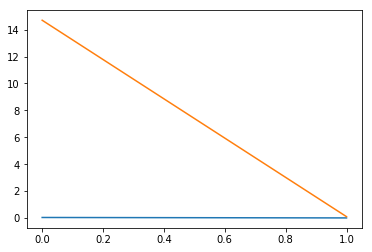

In [9]:
plt.plot(loss_spatial_arr)
plt.plot(loss_rbf_arr)

In [10]:
#np.save('{}/latent_train'.format(Dataset.main),Dataset.latent)

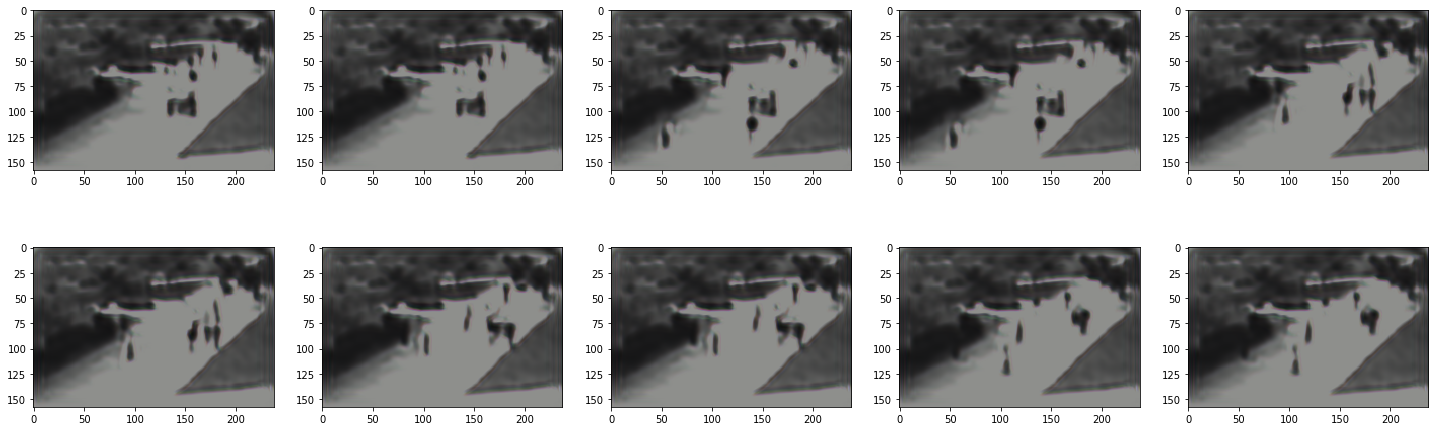

In [11]:
fig, axs = plt.subplots(2,5, figsize=(25,8))
axs = axs.ravel()

for i, imgs in enumerate(Dataset.reproduced_images[10:20]):
    axs[i].imshow(imgs[:,:,:])

In [12]:
Dataset.rbf_out

array([0.98010457, 0.9672002 , 0.97078234, 0.9733487 , 0.98277783,
       0.9792604 , 0.9701962 , 0.9740994 , 0.957177  , 0.97032624,
       0.9686373 , 0.96496683, 0.96279263, 0.97388077, 0.9751409 ,
       0.9691099 , 0.9747273 , 0.96264   , 0.9686834 , 0.9715498 ,
       0.9661132 , 0.9823712 , 0.98568445, 0.9576527 , 0.9676463 ,
       0.97185516, 0.96520174, 0.98108137, 0.96418226, 0.9775029 ,
       0.97542137, 0.97277266, 0.9625942 , 0.9836196 , 0.97094727,
       0.9774857 , 0.97554034, 0.96998644, 0.97420263, 0.9775095 ],
      dtype=float32)

In [13]:
Dataset.reproduced_images.shape

(40, 158, 238, 3)

In [14]:
Dataset.test_images.shape

(400, 158, 238, 3)

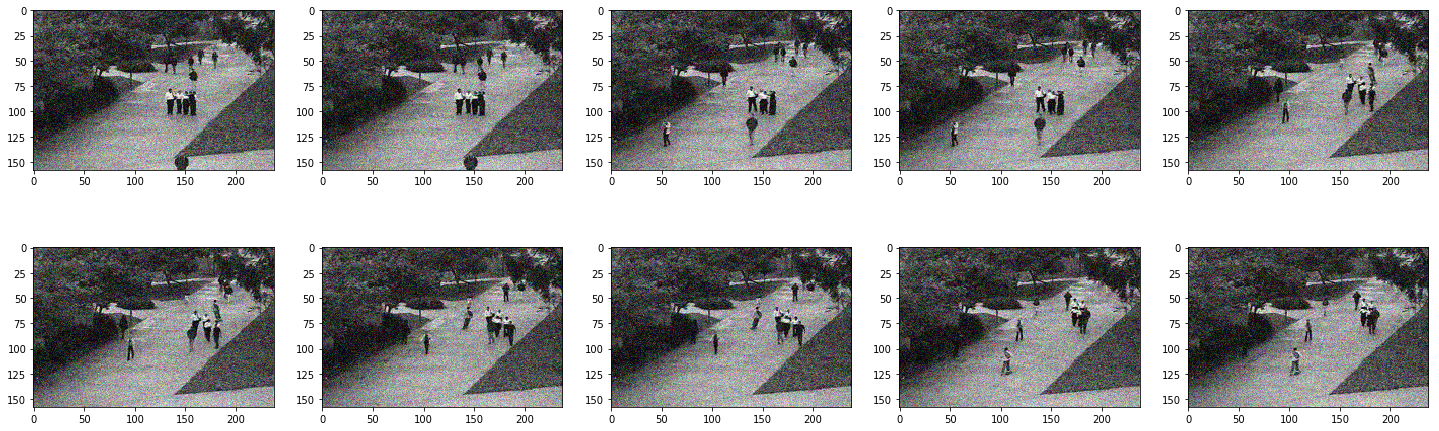

In [15]:
fig, axs = plt.subplots(2,5, figsize=(25,8))
axs = axs.ravel()

for i, imgs in enumerate(Dataset.test_images_[10:20]):
    axs[i].imshow(imgs[:,:,:])